# Chapter 5

`Original content created by Cam Davidson-Pilon`

`Ported to Python 3 and PyMC3 by Max Margenot (@clean_utensils) and Thomas Wiecki (@twiecki) at Quantopian (@quantopian)`
____


### Would you rather lose an arm or a leg?

统计学家可能是酸溜溜的人。他们只是衡量他们失去了多少,而不是考虑他们获得了什么。事实上，他们认为他们的胜利是*负面*的损失。但有趣的是他们如何*衡量他们的损失*。 例如，考虑以下示例：
>气象学家正在预测可能的飓风袭击他的城市的可能性。他估计，以95％的置信度说，它不被触发的概率在99％到100％之间。他对他的精确度非常满意，并建议城市不必要进行大规模撤离。不幸的是，飓风确实发生了，城市被淹没了。

这个风格的例子显示了使用纯精度度量来衡量结果的缺陷。使用强调估计准确性的措施，虽然有吸引力也是*客观的*要做的事，但错过了为什么执行甚至首先执行统计推断的观点：推论结果。*黑天鹅和抗风险*的作者Nassim Taleb强调了决定的*回报*的重要性，而不是准确性。塔莱布简洁扼要地说道：“我宁愿是模糊地正确而不是严重地错误”。

## Loss Functions
我们介绍统计学家和决策理论家称之为*损失函数*的是什么东西。损失函数是有真实参数的函数，也是对该参数的估计

$$ L( \theta, \hat{\theta} ) = f( \theta, \hat{\theta} )$$

损失函数的重点在于它衡量我们目前的估计值有多糟糕：损失越大，估计的损失函数就越差。损失函数的简单且非常常见的示例是平方误差损失：

$$ L( \theta, \hat{\theta} ) = ( \theta -  \hat{\theta} )^2$$

平方误差损失函数用于线性回归，UMVUE和许多机器学习领域的估计。我们也可以考虑一个非对称平方误差损失函数，如：

$$ L( \theta, \hat{\theta} ) = \begin{cases} ( \theta -  \hat{\theta} )^2 & \hat{\theta} \lt \theta \\\\ c( \theta -  \hat{\theta} )^2 & \hat{\theta} \ge \theta, \;\; 0\lt c \lt 1 \end{cases}$$

这表示估计大于真实估计的值比估计低于真实的值更可取。这可能有用的情况是估计下个月的网络流量，其中优先考虑超额估计的前景，以避免服务器资源的分配不足。

关于平方误差损失的负面属性是对大量异常值的过分强调。这是因为损失随着估计的移动而二次增加，而不是线性增加。也就是说，三分之一的罚款远远小于五个单位，但是惩罚并不只是比一个单位远远大一点，尽管在这两种情况下差异的大小是相同的：

$$ \frac{1^2}{3^2} \lt \frac{3^2}{5^2}, \;\; \text{although} \;\; 3-1 = 5-3 $$

这种损失功能使得大的错误非常糟糕。绝对损失是一个更强大的损失函数，其随着差值线性增加

$$ L( \theta, \hat{\theta} ) = | \theta -  \hat{\theta} | $$

其他流行的损失函数包括：
-  $L( \theta, \hat{\theta} ) = \mathbb{1}_{ \hat{\theta} \neq \theta }$ is the zero-one loss often used in machine learning classification algorithms.
-  $L( \theta, \hat{\theta} ) = -\hat{\theta}\log( \theta ) - (1-\hat{ \theta})\log( 1 - \theta ), \; \; \hat{\theta} \in {0,1}, \; \theta \in [0,1]$, called the *log-loss*, also used in machine learning. 

历史上，损失函数的动机来自于1）数学上的便利性，2）它们对于应用是稳健的，即它们是客观的损失度量。第一个原因真的阻止了损失函数的广泛使用。随着计算机在数学上的方便，我们可以自由设计自己的损失函数，我们将在本章后面充分利用。

关于第二点，上述损失函数确实是客观的，因为它们通常是估计和真实参数之间的差异的函数，与选择该估计的标志或收益无关。最后一点，它的收益独立性导致相当病理的结果。考虑我们上面的飓风示例：统计学家等同地预测飓风袭击的概率在0％到1％之间。但是，如果他忽略精确的估计概率，而是结果（99％的机会没有洪水，1％的洪水几率），他可能会有不同的建议。

通过将我们的重点从尝试精确的估计，转移到对参数估计的结果上，我们可以根据我们的应用场景自定义最优的估计结果。这需要我们设计出反映我们目标和结果的新的损失函数。一些更有趣的损失函数的例子：

- $L( \theta, \hat{\theta} ) = \frac{ | \theta - \hat{\theta} | }{ \theta(1-\theta) }, \; \; \hat{\theta}, \theta \in [0,1]$强调估计更接近0或1，因为如果真实的$\theta$接近0或1，那么损失将会非常大，除非$\hat{\theta}$同样接近于0或1.这种损失功能可能被政治专家所使用，他们的工作要求他或她给予自信的“是/否”答案。这种损失反映出，如果真实参数接近1（例如，如果政治结果很可能发生），他或她将强烈同意而不会像一个怀疑论者。

-  $L( \theta, \hat{\theta} ) =  1 - \exp \left( -(\theta -  \hat{\theta} )^2 \right)$ 在0和1之间有界限，反映出用户对足够遥远的估计无动于衷。它类似于上面的零一损失，但不太像惩罚接近真实参数的估计。 

- 复杂的非线性损失函数可编程为：

        def loss(true_value, estimate):
            if estimate*true_value > 0:
                return abs(estimate - true_value)
            else:
               return abs(estimate)*(estimate - true_value)**2
               
- 另一个例子是“信号和噪声”一书。天气预报员对他们的预测有一个有趣的损失函数。

>人们注意到一种类型的错误 - 无法预测下雨，超过其他错误警报。如果不能下雨，他们会诅咒天气预报员来摧毁他们的野餐，而一个意想不到的阳光灿烂的日子被认为是偶然的奖励。

>[天气频道的偏见]仅限于略微夸大不大可能发生的下雨的可能性 - 说如果知道真的只有5％或10％的几率下雨，那么预报员将说有20％的几率——涵盖了他们的屁股都想不到的情况。

正如你所看到的，损失的功能可以用于善恶，具有巨大的力量，很棒 - 你知道。

##  Loss functions in the real world
到目前为止，我们一直在不切实际的假设下，即我们知道真正的参数。当然，如果我们知道真正的参数，那么猜测估计是毫无意义的。因此，当真实参数未知时，损失函数才有意义。 

在贝叶斯推理中，我们有一种观念，即未知参数是具有先验和后验分布的真正随机变量。关于后验分布，从其中得出的值是*可能*是真实参数可能的值。鉴于实际情况，我们可以计算与估计对应的损失。由于我们对未知参数（后验）有一个完整的分布，所以我们应该更有兴趣计算给定估计下的*期望损失*。这种期望损失是对真实损失的更好估计，对比来自后验分布的单个样本的给定损失而言。

首先，解释*贝叶斯点估计*将是有用的。现代世界的系统和机制并不接受后验分布作为输入。当他们要求的是一个估计时，将某个东西交给一个分布也是很粗放的。在个人的一天中，面对不确定性时，依旧将我们的不确定性放在一个单一的行动上并采取行动。类似地，我们需要将我们的后验分布提取到一个单一的值（或多变量的向量）。如果智能地选择这个值，我们可以避免频率派的缺陷，即掩盖不确定性，从而可以提供更多的信息结果。如果从贝叶斯后验中选择值，这就是贝叶斯点估计值。

假设$P(\theta | X)$是在观测数据$X$上的参数$\theta$的后验分布，那么下面的函数是可理解的，因为用*选择的估计值$\hat{\theta}$*去估计$\theta$作为期望的损失：

$$ l(\hat{\theta} ) = E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$

这个被称为$\hat{\theta}$的*风险*。期望符号的下标$\theta$用来表明$\theta$在期望中是未知的（随机）变量，它是我们首先看到难以考虑的变量。

我们花费所有剩下的章节来讨论如何逼近期望值。给定$N$个从后验分布的样本$\theta_i，i=1,\dots,N$，以及一个损失函数$L$，我们可以通过大数定理用估计的$\hat{\theta}$来逼近期望的损失值：

$$\frac{1}{N} \sum_{i=1}^N \;L(\theta_i, \hat{\theta} ) \approx E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right]  = l(\hat{\theta} ) $$

请注意，通过期望值衡量你的损失，会比使用MAP估计（如果你记得，只能找到分布的最大值，并忽略分布的形状），使用分布中的更多信息。忽略信息可能会过度暴露自身到尾部风险，如不太可能的飓风灾害，并且通过更多的无知来减轻自己衡量对模型参数的估计。 

类似地，将这与频率派方法进行比较，传统上只是旨在最小化错误，并且不考虑与该错误的结果相关的损失。综合的说，事实上，频率派方法几乎保证永远不会绝对正确。贝叶斯点估计值通过预先规划来解决这个问题：你的估计会是错的，那么你可能是因为在正确的大方向上选择了错误的东西。

##### Example: Optimizing for the *Showcase* on *The Price is Right*

祝贺你，如果你被选为参加“价格是正确的”比赛的参赛者，这里我们将要告诉你如何在展示栏优化你的最终出价。对于那些忘记规则的人：

1. 两名参赛者在展示栏中竞争价格。 
2. 每位参赛者均被展现一个独一无二的奖品。 
3. 观看后，参赛者将被要求对奖品价格出价。
4. 如果竞标价格超过实际价格，竞标人将被取消资格。 
5. 如果竞标价格低于真实价格250美元以内，则获奖者将获得奖品。

游戏中的困难是平衡你对价格不确定性，保持您的出价足够低以免竞标，并尝试出价接近价格。

假设我们已经记录了以前的*价格是正确的*的出价记录，并且有关于真实价格是什么先验分布。为了简单起见，假设它遵循正太分布：

$$\text{True Price} \sim \text{Normal}(\mu_p, \sigma_p )$$

在后面的一张中，我们实际会使用真正的*价格是正确的*的数据，来构成历史的先验知识，但是这需要一些高级的PyMC3知识，所以我们这里不适用。现在，我们假设$\mu_p=35000$，$\sigma_p = 7500$。

我们需要一个模型用来模拟我们如何展示价格。对于奖品套件中的每个奖品，我们都了解可能会花费多少，但是这个猜测可能与真正的价格有很大的不同。 （加上压力在舞台上，你可以看到为什么一些投标是如此疯狂）。假设你对奖品价格的信念也遵循正态分布：

$$ \text{Prize}_i \sim \text{Normal}(\mu_i, \sigma_i ),\;\; i=1,2$$

这就是为什么贝叶斯分析很好的原因：我们可以通过指定$\mu_i$参数来设定我们认为合理的价格，通过$\sigma_i$表达我们对自己猜测的不确定性。

为了简洁，我们将为每个套件指定两件奖品，但是它可以扩展到任何数量。奖品套件的真实价格由 $\text{Prize}_1 + \text{Prize}_2 + \epsilon$给出,其中$\epsilon$表示一些误差项。

我们对更新后的**真实价格**感兴趣，因为我们已经观察到两个奖品，并且有关于它们价格的先验分布。我们可以使用PyMC3来实现这个。

让我们做的更具体些。假设对于观察到的奖品套件有两个奖品：
1. 到加拿大美丽的多伦多的一次旅行
2. 一个可爱的新吹雪机

我们对这些东西的真实价格有一些猜测，但是我们还是对其非常不确定。我可以表达这种不确定性通过带参数的正太分布：

\begin{align}
& \text{snowblower} \sim \text{Normal}(3 000, 500 )\\\\
& \text{Toronto} \sim \text{Normal}(12 000, 3000 )\\\\
\end{align}

我们可以写一些PyMC3代码来实现对这个奖品套件的价格的推理。

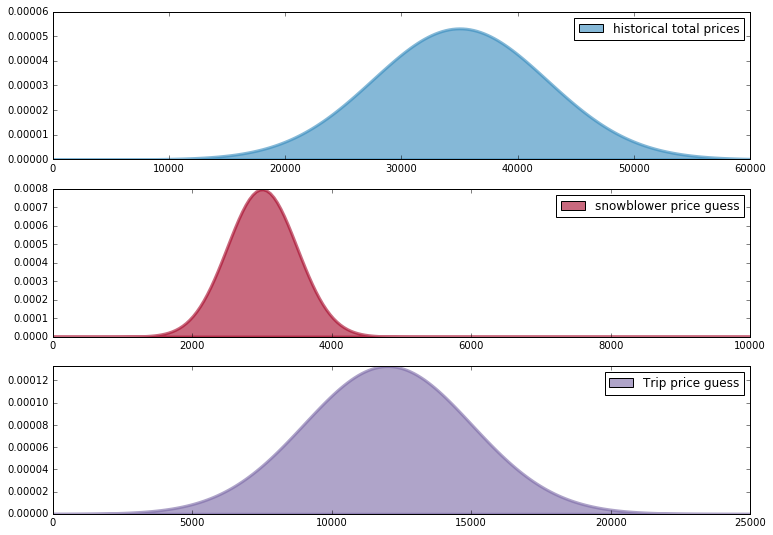

In [1]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt

figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x , 0, norm_pdf(x, 35000, 7500), 
                color = "#348ABD", lw = 3, alpha = 0.6,
                label = "historical total prices")
p1 = plt.Rectangle((0, 0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x , 0, norm_pdf(x, 3000, 500), 
                 color = "#A60628", lw = 3, alpha = 0.6,
                 label="snowblower price guess")

p2 = plt.Rectangle((0, 0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x , 0, norm_pdf(x, 12000, 3000), 
                 color = "#7A68A6", lw = 3, alpha = 0.6,
                 label = "Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0, 0), 1, 1, fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()]);

In [2]:
import pymc3 as pm

data_mu = [3e3, 12e3]

data_std =  [5e2, 3e3] 

mu_prior = 35e3
std_prior =  75e2
with pm.Model() as model:
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=data_mu[0], sd=data_std[0])
    prize_2 = pm.Normal("second_prize", mu=data_mu[1], sd=data_std[1])
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)
    

    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]

price_trace = burned_trace["true_price"]

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50500/50500 [00:36<00:00, 1381.22it/s]


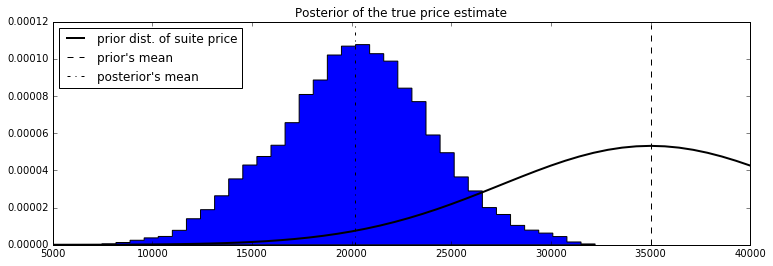

In [3]:
figsize(12.5, 4)

import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, 
         label = "prior dist. of suite price")

_hist = plt.hist(price_trace, bins = 35, normed= True, histtype= "stepfilled")
plt.title("Posterior of the true price estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label = "prior's mean",
           linestyles="--")
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]), \
           label = "posterior's mean", linestyles="-.")
plt.legend(loc = "upper left");

请注意，由于我们两次观察到的奖品和随后的猜测（包括这些猜测的不确定性），我们将平均价格估计从之前的平均价格下调了约15,000美元。 

一个频率派的人，看到这两个奖品，对于他们的价格有相同的看法，无论任何不确定性，将出价$\mu_1 + \mu_2 = 35000$。同时，*朴素的贝叶斯*将简单地选择后验分布的平均值。但是我们有更多关于我们最终结果的信息;我们应该把它纳入我们的竞标。我们将使用上面的损失函数找到*最佳*出价（最好是根据我们的损失）。 

参赛者的损失函数可能是什么样的？我会认为它会像：

    def showcase_loss(guess, true_price, risk = 80000):
        if true_price < guess:
            return risk
        elif abs(true_price - guess) <= 250:
            return -2*np.abs(true_price)
        else:
            return np.abs(true_price - guess - 250)
            
`risk`是一个参数，它定义了如果你的猜测超过了真实价格，那么它的糟糕程度。`risk`较低意味着你对过去的想法更为舒适。如果我们出价的价差少于250美元，我们会收到两个奖品（在这里获得原奖品的两倍）。否则，当我们根据`true_price`进行竞价时，我们希望尽可能的接近，`else`损失是猜测和真实价格之间的增函数。

对于每个可能的出价，我们计算与该出价相关的*期望损失*。我们改变`risk`参数，看看它是如何影响我们的损失的：

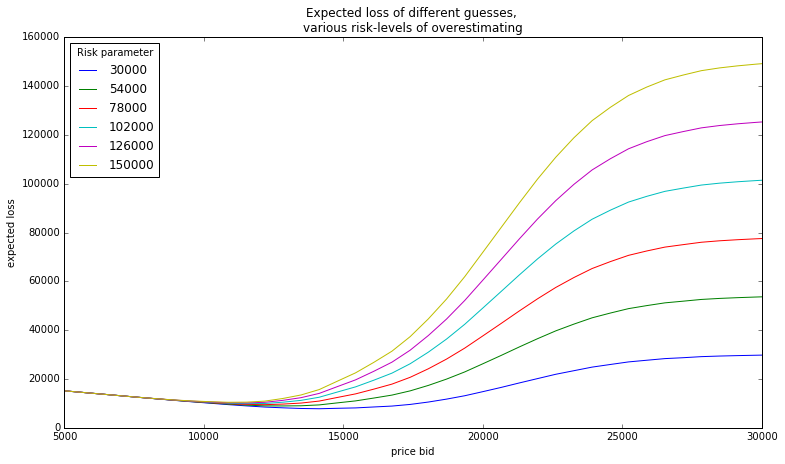

In [4]:
figsize(12.5, 7)
#numpy friendly showdown_loss


def showdown_loss(guess, true_price, risk = 80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70) 
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()
        
for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)
    
plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);

### Minimizing our losses
选择最小化我们的期望损失是明智的。这对应于上述每条曲线上的最小点。更正式地，我们希望通过找到解决方案来最大限度地减少我们期望损失

$$ \text{arg} \min_{\hat{\theta}} \;\;E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$

期望损失的最低值称为*贝叶斯行动*。我们可以使用Scipy的优化例程来解决Bayes action。`scipy.optimize`模块中的使用智能搜索来找到任何单变量或多变量函数的最小值（不一定是全局最小值）。对于大多数用途，`fmin`将提供一个很好的答案。

我们将计算上述Showcase示例的最小损失：

minimum at risk 30000: 14115.35
minimum at risk 54000: 12578.68
minimum at risk 78000: 11909.09
minimum at risk 102000: 11906.91
minimum at risk 126000: 11360.40
minimum at risk 150000: 11205.54


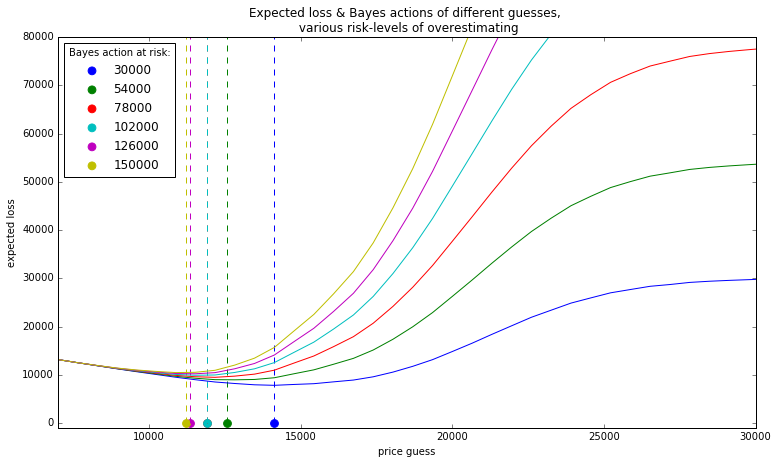

In [5]:
import scipy.optimize as sop

ax = plt.subplot(111)


for _p in risks:
    _color = next(ax._get_lines.prop_cycler)
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,),disp = False)
    _results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, _results , color = _color['color'])
    plt.scatter(_min_results, 0, s = 60, \
                color= _color['color'], label = "%d"%_p)
    plt.vlines(_min_results, 0, 120000, color = _color['color'], linestyles="--")
    print("minimum at risk %d: %.2f" % (_p, _min_results))
                                    
plt.title("Expected loss & Bayes actions of different guesses, \n \
various risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints = 1, title = "Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000, 30000)
plt.ylim(-1000, 80000);

正如直觉所示，随着我们降低风险门槛（关心过低），我们提高出价，愿意接近真正的价格。有趣的是，我们的最优的损失距离后验平均值有多远，约为20 000。 

可以说，在更高的维度上能够用肉眼查看最小的期望损失是不可能的。所以为什么我们需要使用Scipy的`fmin`函数。

______

### Shortcuts
对于一些损失函数，贝叶斯行动有封闭形式公式。我们列出下列其中一些：
- 如果使用均方误差，则贝叶斯行动是后验分布的平均值，即该值$ E_{\theta}\left[ \theta \right] $ minimizes $E_{\theta}\left[ \; (\theta - \hat{\theta})^2 \; \right]$。在计算上，这要求我们计算后验样本的平均值[见“大数法”第4章）
- 而后验分布的*中位数*最小化了期望的绝对损失。后验样本的样本中值对真实中位数的是非常准确的近似。
- 实际上，有可能表明MAP估计是使将损失收缩到0-1损失函数的解决方案。

也许现在可以很清楚，为什么在贝叶斯推理的数学中最常使用的是那个首先介绍的损失函数：不需要复杂的优化。幸运的是，我们有机器为我们做复杂的事情。

##  Machine Learning via Bayesian Methods
频繁派力求达到对所有可能参数的最佳精度估计，机器学习力求在所有可能的参数之间实现最佳*预测*。当然，实现准确预测的一种方法是为了准确预测，但是通常你的预测好坏的度量和频率派的优化方式是非常不同的。 

例如，最小二乘线性回归是最简单的主动机器学习算法。我说主动是因为它参与到学习，而预测样本平均值在技术上更*简单*，但是对任何事情，学习到的东西很少。确定回归系数的损失是平方误差损失。另一方面，如果你的预测损失函数（或分数函数，即负损失）不是像平方误差（如AUC，ROC，精度等），则最小二乘法线将不会是预测的最佳值损失函数。这可能导致不太理想的预测结果。

寻找贝叶斯行为相当于找到不优化参数的正确度而是优化任意性能的度量，但是我们希望定义性能（损失函数，AUC，ROC，准确度/回叫率等）。 

接下来的两个例子展示了这些想法。第一个例子是一个线性模型，我们可以选择使用最小二乘法损失或新的对结果敏感的损失进行预测。 

第二个例子是从Kaggle数据科学项目改编而来。与我们的预测相关的损失函数是非常复杂的。

##### Example: Financial prediction

假设股票的未来回报率非常小，说0.01（或1％）。我们有一个预测股票未来价格的模型，我们的利润和亏损与我们的预测直接相关。我们应如何衡量损失和模型预测的关系，以及随后的预测？平方误差损失与正负号无关，并且对-0.01和0.03作出相同的惩罚：

$$ (0.01 - (-0.01))^2 = (0.01 - 0.03)^2 = 0.004$$

如果你根据模型的预测进行了下注，那么你将因为预测值为0.03赚取收益，并以预测值为-0.01输掉资金，但我们的损失函数并没有捕捉到这一点。我们需要考虑到一个考虑到预测和真实值的正负号的损失函数。我们设计出新的损失，以适合以下金融应用：

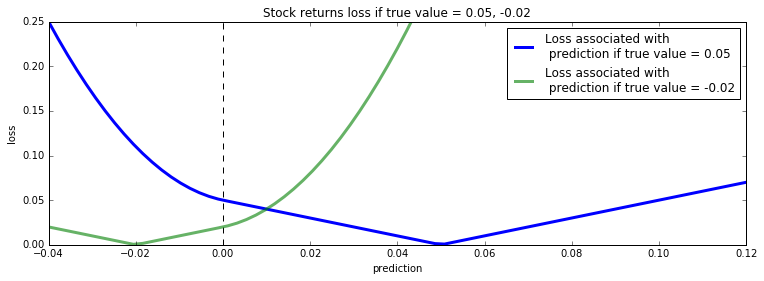

In [6]:
figsize(12.5, 4)


def stock_loss(true_return, yhat, alpha = 100.):
    if true_return * yhat < 0:
        #opposite signs, not good
        return alpha*yhat**2 - np.sign(true_return)*yhat \
                        + abs(true_return) 
    else:
        return abs(true_return - yhat)
    
    
true_value = .05
pred = np.linspace(-.04, .12, 75)

plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], \
        label = "Loss associated with\n prediction if true value = 0.05", lw =3) 
plt.vlines(0, 0, .25, linestyles="--")

plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-0.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(pred, [stock_loss(true_value, _p) for _p in pred], alpha = 0.6, \
        label = "Loss associated with\n prediction if true value = -0.02", lw =3) 
plt.legend()
plt.title("Stock returns loss if true value = 0.05, -0.02");

注意，随着预测跨越零，损失形状的变化。这种损失反映出用户真的不想猜错正负号，特别是错误很大的时候。 

为什么用户关心量的大小？为什么损失不是0来代表正确的符号预测？当然，如果回报为0.01，我们下定价数百万，我们仍然会非常开心。 

金融机构处理下行风险，就是在错误的一面预测了很多值，以及上涨的风险，就是在正确的一面预测了很多值。两者都被视为有风险的行为，并且不鼓励。这是导致为什么我们在远离真实价格的时候损失越来越多。（在正确符号方向上损失较少） 

我们将对交易信号进行回归，这是因为我们认为预测未来的回报会是良好的。我们的数据集是人造的，因为大多数财务数据甚至不接近线性。下面我们绘制数据以及最小二乘线。

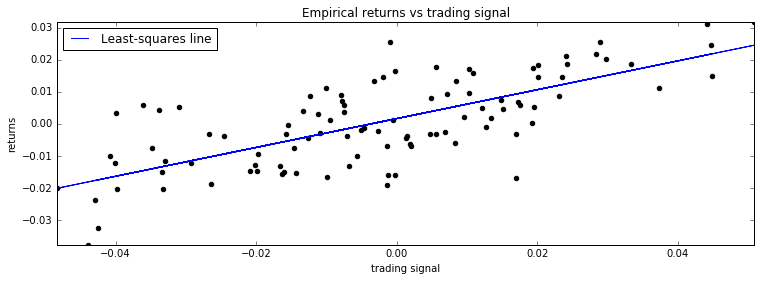

In [7]:
## Code to create artificial data
N = 100
X = 0.025*np.random.randn(N)
Y = 0.5*X + 0.01*np.random.randn(N) 

ls_coef_ = np.cov(X, Y)[0,1]/np.var(X)
ls_intercept = Y.mean() - ls_coef_*X.mean()

plt.scatter(X, Y, c="k")
plt.xlabel("trading signal")
plt.ylabel("returns")
plt.title("Empirical returns vs trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label = "Least-squares line")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

我们在这个数据集上实施简单的贝叶斯线性回归。我们看到其模型为：

$$ R = \alpha + \beta x + \epsilon$$

其中$\alpha$,$\beta$是我们的位置参数，并且$\epsilon \sim \text{Normal}(0, \sigma)$。最常见的$\alpha$和$\beta$的先验分布是正太分布。我们还要对$\sigma$指定一个uniform分布，范围从[0,100]。

In [8]:
import pymc3 as pm

with pm.Model() as model:
    std = pm.Uniform("std", 0, 100)
    
    beta = pm.Normal("beta", mu=0, sd=100)
    alpha = pm.Normal("alpha", mu=0, sd=100)
    
    mean = pm.Deterministic("mean", alpha + beta*X)
    
    obs = pm.Normal("obs", mu=mean, sd=std, observed=Y)
    
    trace = pm.sample(100000, step=pm.Metropolis())
    burned_trace = trace[20000:]  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100500/100500 [31:45<00:00, 52.75it/s]


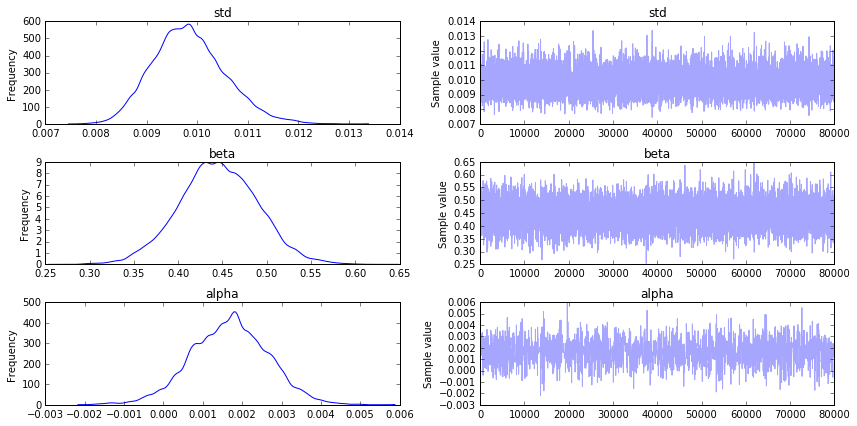

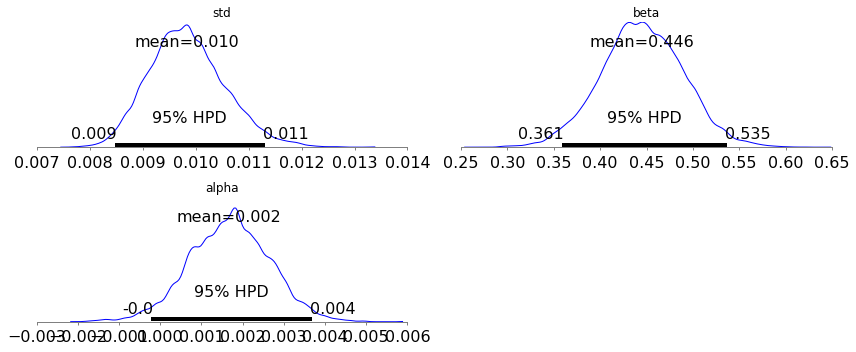

In [9]:
pm.plots.traceplot(trace=burned_trace, varnames=["std", "beta", "alpha"])
pm.plot_posterior(trace=burned_trace, varnames=["std", "beta", "alpha"], kde_plot=True);

看上去MCMC已经收敛了，所以我们可以继续。

对一个指定好的交易信号，称它为$x$，可能的回报的分布可以表示为：

$$R_i(x) =  \alpha_i + \beta_ix + \epsilon $$

其中，$\epsilon \sim \text{Normal}(0, \sigma_i)$ 和 $i$ 索引了我们的后验样本。我们希望找到关于$r$的解决方案能够：

$$ \arg \min_{r} \;\;E_{R(x)}\left[ \; L(R(x), r) \; \right] $$

根据上面给出的损失函数。$r$就是我们贝叶斯行为对于交易信号$x$的反应。下面我们画出在不同交易信号的贝叶斯行为。你注意到什么了？

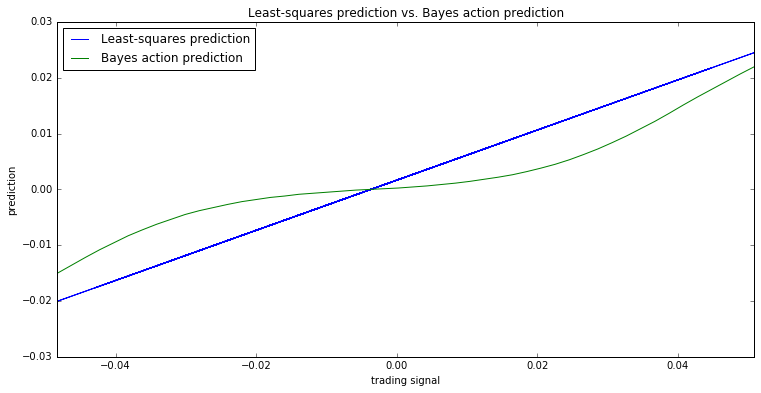

In [10]:
figsize(12.5, 6)
from scipy.optimize import fmin


def stock_loss(price, pred, coef = 500):
    """vectorized for numpy"""
    sol = np.zeros_like(price)
    ix = price*pred < 0 
    sol[ix] = coef*pred**2 - np.sign(price[ix])*pred + abs(price[ix])
    sol[~ix] = abs(price[~ix] - pred)
    return sol

std_samples = burned_trace["std"]
alpha_samples = burned_trace["alpha"]
beta_samples = burned_trace["beta"]

N = std_samples.shape[0]

noise = std_samples*np.random.randn(N) 

possible_outcomes = lambda signal: alpha_samples + beta_samples*signal + noise


opt_predictions = np.zeros(50)
trading_signals =  np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
        _possible_outcomes = possible_outcomes(_signal)
        tomin = lambda pred: stock_loss(_possible_outcomes, pred).mean()
        opt_predictions[i] = fmin(tomin, 0, disp = False)
        
        
plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action prediction")
plt.plot(X, ls_coef_*X + ls_intercept, label ="Least-squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label ="Bayes action prediction")
plt.legend(loc="upper left");

上面的图表有趣的是，当信号接近0时，许多可能的回报结果可能是正的和负的，我们最好的（相对于我们的损失）预测是接近0的预测，因此*我们不采取行动*。只有当我们非常有信心，我们才在某个位置进入。我将这种模式称为*稀疏预测*，我们对我们的不确定性感到不舒服，所以选择不采取行动。（与最少平方预测比较，很少做出预测，如果有的可能的话，预测为零）。

良好的理性检查后，我们的模型仍然是合理的：随着信号变得越来越极端，我们对正回报/负回报感到越来越有信心，我们与最小二乘线的收敛位置一致。

稀疏预测模型不是试图去最好的*拟合*数据（根据拟合的平方误差损失定义），那个属于最小二乘法模型。稀疏预测模型试图找到关于我们`stock_loss`定义的损失的最佳预测。我们可以把这个推开：最小二乘模型不是试图*预测*最好的（根据`stock-loss`对预测的定义）,这个目标是属于稀疏预测模型。最小二乘模型试图找出数据相对于*平方误差*损失的最佳拟合。

##### Example: Kaggle contest on *Observing Dark World*
学习贝叶斯方法的个人动机是试图将胜利解决方案拼凑到Kaggle的[观察黑暗世界](http://www.kaggle.com/c/DarkWorlds)大赛。从比赛网站：

>宇宙中存在的东西比眼睛能够看到的更多。在宇宙中存在一种物质形态，超过了我们可以看到的东西的数量，几乎7 to 1，并且我们不知道它是什么。我们所知道的是它不会发出或吸收光，所以我们称之为“黑暗物质”。这样的大量聚合物质不会被忽视。事实上，我们观察到这个东西聚集并形成了称为Dark Matter Halos的大规模结构。虽然黑暗，它扭曲和弯曲时空，使得任何通过接近暗物质的背景星系的光将改变和改变它的路径。这种弯曲使星系在天空中呈现为椭圆形。

<img src="http://timsalimans.com/wp-content/uploads/2012/12/dm.jpg" width = 730>

比赛需要预测暗物质可能在哪里。获胜者蒂姆·萨利曼（Tim Salimans）使用贝叶斯推理来找到光环的最佳位置（有趣的是，第二名获胜者也使用贝叶斯推理）。在蒂姆允许的情况下，我们在这里提供了他的解决方案[1]：
1. 构造光晕位置$p(x)$的先验分布，即在查看数据之前就制定我们对光环位置的估计。 
2. 给出暗物质光晕的位置$p(e | x)$的前提下，构建数据（观察到的星系的椭圆度）的概率模型。 
3. 使用贝叶斯规则获得光晕位置的后验分布，即使用数据来猜测暗物质光晕可能在哪里。 
4. 在对应的预测的光晕的位置的后验分布下，最小化期望的损失： $\hat{x} = \arg \min_{\text{prediction} } E_{p(x|e)}[ L( \text{prediction}, x) ]$。也就是说在给定我们的损失度量的前提下，调整我们的预测值，以便能够使得损失最下。

这个问题的损失函数非常复杂。对于非常确定的损失函数包含在父文件夹中的DarkWorldsMetric.py文件中。虽然我建议不要全部阅读，但足以说出损失函数是大约160行代码——而不是可以在单行中写下来的东西。那个损失函数尝试在欧几里得距离中测量预测的准确性，使得不存在偏移偏差。更多详细信息可以在度量标准的主页上找到[main page](http://www.kaggle.com/c/DarkWorlds/details/evaluation)。 

我们将尝试使用PyMC3实现Tim的获胜解决方案以便我们加深对损失函数的了解。

### The Data

The dataset is actually 300 separate files, each representing a sky. In each file, or sky, are between 300 and 720 galaxies. Each galaxy has an $x$ and $y$ position associated with it, ranging from 0 to 4200, and measures of ellipticity: $e_1$ and $e_2$. Information about what these measures mean can be found [here](https://www.kaggle.com/c/DarkWorlds/details/an-introduction-to-ellipticity), but for our purposes it does not matter besides for visualization purposes. Thus a typical sky might look like the following:

### The Data
数据集实际上是300个单独的文件，每个文件代表一个天空。在每个文件或天空中，都在300到720个星系之间。每个星系有一个与这个sky相关联的位置$x$和$y$，范围从0到4200，以及椭圆度的测量：$e_1$和$e_2$。关于这些度量意味着什么的信息可以在[这里](https://www.kaggle.com/c/DarkWorlds/details/an-introduction-to-ellipticity)找到，但为了我们的目的，除了可视化目的外，没有其他的关系了。因此，典型的天空可能如下所示：

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2 
[[  1.62690000e+02   1.60006000e+03   1.14664000e-01  -1.90326000e-01]
 [  2.27228000e+03   5.40040000e+02   6.23555000e-01   2.14979000e-01]
 [  3.55364000e+03   2.69771000e+03   2.83527000e-01  -3.01870000e-01]]


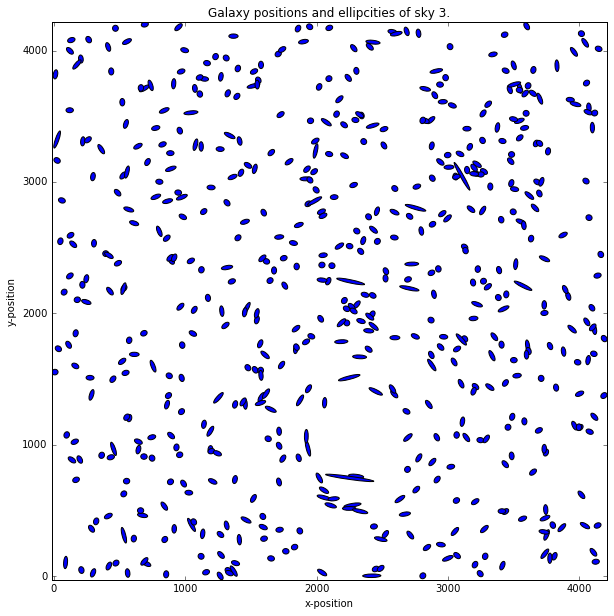

In [11]:
from draw_sky2 import draw_sky

n_sky = 3 #choose a file/sky to examine.
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])
print("Data on galaxies in sky %d."%n_sky)
print("position_x, position_y, e_1, e_2 ")
print(data[:3])

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position");

### Priors
每个天空都有1到2或者3个黑物质光晕。Tim的方案里关于光晕位置的先验分布是uniform,即：
\begin{align}
& x_i \sim \text{Uniform}( 0, 4200)\\\\
& y_i \sim \text{Uniform}( 0, 4200), \;\; i=1,2,3\\\\
\end{align}

Tim和其他竞赛者注意到大多数天空都有1个大的光晕和其他光晕（如果存在的话）。大的光晕，有更大的质量，将会更多的对其周围的星系产生影响。他决定让最大的光晕的质量分布符合一个*log-uniform*随机变量，其范围在[40, 180]之间，即：

$$  m_{\text{large} } = \log \text{Uniform}( 40, 180 ) $$

在PyMC3中，

    exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
    mass_large = pm.Deterministic("mass_large", np.log(exp_max_large))
    
（这就是我们说*log-uniform*是啥意思）。对小的星系，Tim让其质量是logarithm of 20。为什么Tim不对小的星系建立一个先验分布呢，或者认为它是未知量？我相信这个决定使得算法的收敛得到了加速。这样就没有太多的限制，即通过在星系中，构造小的星系产生更小的影响。

Tim逻辑地假设每个星系的椭圆度取决于光晕的位置，星系与光晕之间的距离以及光晕的质量。因此每个星系的椭圆率向量$\mathbf{e}_i$是由光晕位置 $(\mathbf{x},\mathbf{y})$，距离(我们将要formalize它），以及光晕质量。

Tim通过阅读文献和论坛帖子确定了连接位置和椭圆率之间关系的一种构想。他认为以下是一个合理的关系：

$$ e_i | ( \mathbf{x}, \mathbf{y} ) \sim \text{Normal}( \sum_{j = \text{halo positions} }d_{i,j} m_j f( r_{i,j} ), \sigma^2 ) $$

其中$d_{i,j}$是切线方向（光晕$j$弯曲星系$i$光线的方向），$m_j$是光晕$j$的质量，$f(r_{i.j})$是一个光晕$j$和星系$i$之间欧几里得距离的减函数。

对大的光晕，Tim的函数$f$定义为：

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 240 ) } $$

对小的光晕，函数$f$定义为：

$$ f( r_{i,j} ) = \frac{1}{\min( r_{i,j}, 70 ) } $$

这完全交接了我们的观察数据和未知量。这个模型非常的简洁，Tim提到这种简单性是有目的的：它可以防止模型过拟合。

### Training & PyMC3 implementation
对于每个天空，我们运行我们的贝叶斯模型来找到光晕位置的后验分布——我们忽略（已知）的光晕位置。这与Kaggle比赛的传统方法略有不同，该模型不使用其他天空的数据，也不使用已知的光晕位置。这并不意味着其他数据不是必要的——实际上，模型是通过比较不同的天空来创建的。

In [12]:
import pymc3 as pm
import theano.tensor as T

def euclidean_distance(x, y):
    return np.sqrt(((x - y)**2)).sum(axis=1)

def f_distance(gxy_pos, halo_pos, c):
    # foo_position should be a 2-d numpy array
    # T.maximum() provides our element-wise maximum as in NumPy, but instead for theano tensors
    return T.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:, None]

def tangential_distance(glxy_position, halo_position):
    # foo_position should be a 2-d numpy array
    delta = glxy_position - halo_position
    t = (2*T.arctan(delta[:,1]/delta[:,0]))
    return T.stack([-T.cos(t), -T.sin(t)], axis=1)


with pm.Model() as model:
    #set the size of the halo's mass
    mass_large = pm.Uniform("mass_large", 40, 180)
    
    #set the initial prior position of the halos, it's a 2-d Uniform dist.
    halo_position = pm.Uniform("halo_position", 0, 4200, shape=(1,2))
    
    mean = pm.Deterministic("mean", mass_large /\
            f_distance(T.as_tensor(data[:,:2]), halo_position, 240)*\
            tangential_distance(T.as_tensor(data[:,:2]), halo_position))
    
    ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])

In [13]:
with model:
    mu, sds, elbo = pm.variational.advi(n=50000)
    step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
    trace = pm.sample(5000, step=step, start=mu)

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
  from ipykernel import kernelapp as app
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5500/5500 [4:39:45<00:00,  3.26s/it]


我们在这里使用ADVI为我们的NUTS采样器找到一个很好的起始点和缩放。NUTS是一个比Metropolis更“聪明”的MCMC采样方法，因此我们需要更少的总体样本来使我们的马尔科夫链收敛。ADVI遵循完全不同的方法来拟合一个模型。我们也许会在后面的章节深入介绍ADVI以及NUTS。

下面我们绘制后验分布的热力图。（这只是后验分布的散点图，但是我们可以将其可视化为热力图）

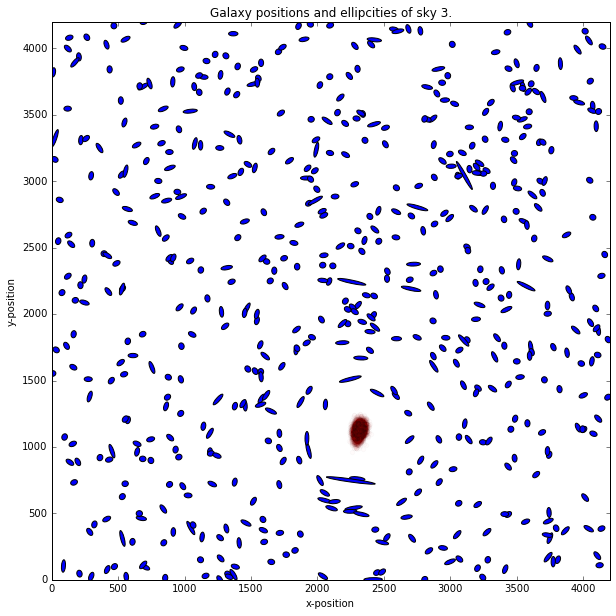

In [14]:
t = trace["halo_position"].reshape(5000,2)

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

那个最可能的位置标明它就是一个致命的伤害。

和每个天空相关联的另一个数据点位于`.data/Training_halos/csv`，其中的一行记录包含了天空中最多三个暗物质光晕的位置。比如，我们训练的夜空有光晕位置：

In [15]:
halo_data = np.genfromtxt("data/Training_halos.csv", 
                          delimiter = ",",
                          usecols = [1, 2,3, 4,5,6,7,8,9],
                          skip_header = 1)
print(halo_data[n_sky])

[  1.00000000e+00   1.40861000e+03   1.68586000e+03   1.40861000e+03
   1.68586000e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


第三列和第四列表示光晕的真实位置 xx 和 yy 。可以看到贝叶斯方法已经将这个光晕定位在一个紧致的范围内。

True halo location: 1408.61 1685.86


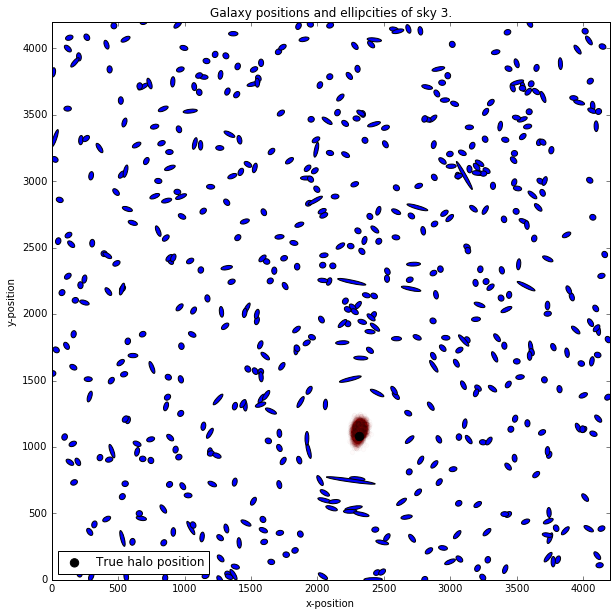

In [16]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha = 0.015, c = "r")
plt.scatter(halo_data[n_sky-1][3], halo_data[n_sky-1][4], 
            label = "True halo position",
            c = "k", s = 70)
plt.legend(scatterpoints = 1, loc = "lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200);

print("True halo location:", halo_data[n_sky][3], halo_data[n_sky][4])

完美。我们的下一步是使用损失函数优化我们的位置。一个简单的策略是简单地选择平均值：

In [17]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print(mean_posterior)

[[ 2312.55071197  1126.77711188]]


In [18]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky-1]

nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior

print("Using the mean:")
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score(nhalo_all, x_true_all, y_true_all, \
            x_ref_all, y_ref_all, random_guess)

Using the mean:
Your average distance in pixels you are away from the true halo is 44.9432782558
Your average angular vector is 1.0
Your score for the training data is 1.04494327826
Using a random location: [[2234 1562]]
Your average distance in pixels you are away from the true halo is 486.966088039
Your average angular vector is 1.0
Your score for the training data is 1.48696608804


1.4869660880389928

这是一个很好的猜测，它离真实的位置并不很远，但它忽略了提供的损失函数。我们还需要扩展我们的代码，允许最多添加两个更小的光环：让我们创建一个自动化我们的PyMC3的函数。

In [19]:
def halo_posteriors(n_halos_in_sky, galaxy_data,samples = 5e5, burn_in = 500):
    #set the size of the halo's mass
    with pm.Model() as model:
        mass_large = pm.Uniform("mass_large", 40, 180)
        
        mass_small_1 = 20
        mass_small_2 = 20
    
        masses = np.array([mass_large,mass_small_1, mass_small_2], dtype=object)
    
        #set the initial prior positions of the halos, it's a 2-d Uniform dist.
        halo_positions = pm.Uniform("halo_positions", 0, 4200, shape=(n_halos_in_sky,2)) #notice this size
    
        fdist_constants = np.array([240, 70, 70])
        
        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += masses[i]/f_distance(data[:,:2], halo_positions[i, :], fdist_constants[i])*\
                tangential_distance(data[:,:2], halo_positions[i, :])
        
        mean = pm.Deterministic("mean", _sum)
               
        ellpty = pm.Normal("ellipcity", mu=mean, tau=1./0.05, observed=data[:,2:])
    
        mu, sds, elbo = pm.variational.advi(n=50000)
        step = pm.NUTS(scaling=model.dict_to_array(sds), is_cov=True)
        trace = pm.sample(samples, step=step, start=mu)
        
    burned_trace = trace[burn_in:]
    return burned_trace["halo_positions"]

In [ ]:
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Train_Skies/\
Training_Sky%d.csv" % (n_sky),
                      dtype = None,
                      skip_header = 1,
                      delimiter = ",",
                      usecols = [1,2,3,4])

In [ ]:
#there are 3 halos in this file. 
samples = 5000
traces = halo_posteriors(3, data, samples = samples, burn_in=500)

D:\Users\ZB-TQ-G1010448\Anaconda3\lib\site-packages\ipykernel\__main__.py:24: DeprecationWarning: Old ADVI interface and sample_vp is deprecated and will be removed in future, use pm.fit and pm.sample_approx instead
Average ELBO = 134.01:  61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 30503/50000 [2:31:29<1:37:20,  3.34it/s]

In [ ]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0],  traces[:, i, 1], c = colors[i], alpha = 0.02)
    
    
for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky-1][3 + 2*i], halo_data[n_sky-1][4 + 2*i], 
            label = "True halo position", c = "k", s = 90)
    
#plt.legend(scatterpoints = 1)
plt.xlim(0, 4200)
plt.ylim(0, 4200);

这看起来相当不错，尽管系统需要花费很长时间（收敛）。我们的优化步骤将如下所示：

In [ ]:
_halo_data = halo_data[n_sky-1]
print(traces.shape)

mean_posterior = traces.mean(axis=0).reshape(1,6)
print(mean_posterior)


nhalo_all =  _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior


print("Using the mean:")
main_score([1], x_true_all, y_true_all, \
            x_ref_all, y_ref_all, sky_prediction)

#what's a bad score?
random_guess = np.random.randint(0, 4200, size=(1,2))
print("Using a random location:", random_guess)
main_score([1], x_true_all, y_true_all, \
            x_ref_all, y_ref_all, random_guess)

## References
1. Antifragile: Things That Gain from Disorder. New York: Random House. 2012. ISBN 978-1-4000-6782-4.
1.  [Tim Saliman's solution to the Dark World's Contest](http://www.timsalimans.com/observing-dark-worlds)
2. Silver, Nate. The Signal and the Noise: Why So Many Predictions Fail — but Some Don't. 1. Penguin Press HC, The, 2012. Print.

In [ ]:
from IPython.core.display import HTML
def css_styling():
    styles = open("../styles/custom.css", "r").read()
    return HTML(styles)
css_styling()